In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os

In [2]:
# MAKE CUSTOM FEATURES
from additional_features.make_features import make_all_features


In [3]:
from kaggle_submit import submit_to_kaggle
from helpers import *
from utils.globals import *
from utils.distribution_statistics import *
from objects import *

train_file = "kaggle_data/X_train.h5/X_train.h5"
test_file = "kaggle_data/X_test.h5/X_test.h5"

h5_train = h5py.File(train_file, mode='a')
h5_test = h5py.File(test_file, mode='a')

y_train = pd.read_csv("kaggle_data/y_train.csv", index_col=0, squeeze=True)
y_train_arr = y_train.to_numpy()

make_all_features(h5_train,h5_test,n_chunks=10, verbose=True, overwrite=False)

In [4]:
def ensure_integrity(h5_file):
    keys = list(h5_file.keys())
    for i, key in enumerate(keys):
        print_bis(f'{i+1}/{len(keys)}')
        x = h5_file[key][:]
        assert np.sum(np.isnan(x)) == 0
        assert np.sum(np.isinf(x)) == 0
        
# ensure_integrity(h5_train)
# ensure_integrity(h5_test)

In [5]:
"""
# SAVE MODEL

from joblib import dump, load
ARCHIVES_FOLDER = "models_archives"
if not os.path.exists(ARCHIVES_FOLDER):
    os.makedirs(ARCHIVES_FOLDER)

def save_model(model, name):
    fpath = os.path.join(ARCHIVES_FOLDER, f"{name}.joblib")
    dump(model, fpath)
    print(f"New model saved at {fpath}")
    return fpath
    
    
def load_model(name):
    if not name.startswith(ARCHIVES_FOLDER):
        name = os.path.join(ARCHIVES_FOLDER, name)
    if not name.endswith(".joblib"):
        name = f"{name}.joblib"
    model = load(name)
    return model

LEADERBOARD_FILE = "leaderboard.txt"
if not os.path.exists(LEADERBOARD_FILE):
    with open(LEADERBOARD_FILE, 'a') as leaderboard:
        leaderboard.write(";;;".join(['path', 'training_score', 'validation_score', 'comments']))
    
def write_model_to_leaderboard(model, model_name, train_score, val_score, comments=""):
    fpath = save_model(model, model_name)
    with open(LEADERBOARD_FILE, "a") as leaderboard:
        leaderboard.write("\n" + ';;;'.join([fpath, str(train_score), str(val_score), comments]))
    
"""
_ = ""

In [6]:
## Input maker

def make_input_for_svm_extreme(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=TAIL_QUANTILES, dist_char=False, truncate_dist=False,
                     rescale=True, time_features=TIME_FEATURES, orders=[0], log_for_frequential=False)

svm_extreme_input_maker = InputMaker(make_input_for_svm_extreme)

## input shaper
import re
from sklearn.preprocessing import StandardScaler

pca_cols_filters = [
    lambda x: 'eeg' in x[0] and 'logmod' in x[0], 
    lambda x: bool(re.search('eeg_\d', x[0])),
]

pca_list = [CustomPCA(columns_filter=filt, name=f"PCA_{i}", var_capture=0.95) for i, filt in enumerate(pca_cols_filters)]

svm_extreme_input_shaper = InputShaper(*pca_list, StandardScaler())

## parameters grid
from sklearn.model_selection import ParameterGrid

svm_grid_1 = ParameterGrid({"kernel": ["rbf", "sigmoid"],
                            "C": [0.01, 0.1, 1, 10, 100],
                            "gamma": ["auto", "scale"]}
                          )
svm_grid_2 = ParameterGrid({"kernel": ["poly"],
                            "C": [0.01, 0.1, 1, 10, 100],
                            "degree": [1, 2, 3, 4]}
                          )
svm_hyperparameters = list(svm_grid_1) + list(svm_grid_2)


# generic object
from sklearn.svm import SVC

svm_extreme = PoolModels(
    input_maker=svm_extreme_input_maker,
    n_splits=5,
    train_size=27,
    input_shaper=svm_extreme_input_shaper,
    blueprint=SVC,
    parameters_list=svm_hyperparameters,
    warming_params={"max_iter":50},
    convergence_params={"max_iter": -1},
    seed=3,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)



/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


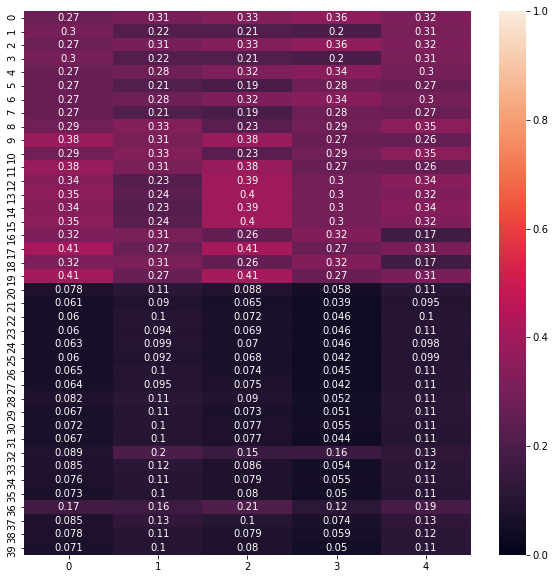

In [7]:
# train
import matplotlib.pyplot as plt
svm_extreme.warm_up()
svm_extreme.plot_validation()
plt.show()
best_svm_extremes = svm_extreme.train_n_best_models_until_convergence(1)

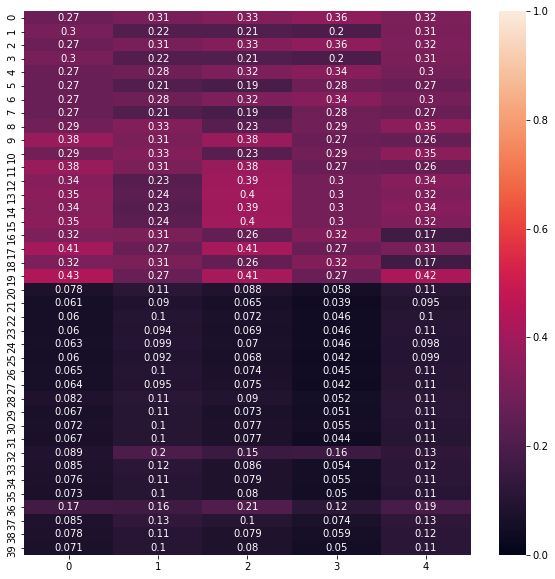

array([[0.27493308, 0.30647816, 0.33071595, 0.36146312, 0.32004556],
       [0.30371342, 0.21735797, 0.21473435, 0.19938395, 0.31426424],
       [0.27493308, 0.30647816, 0.33071595, 0.36146312, 0.32004556],
       [0.30371342, 0.21735797, 0.21473435, 0.19938395, 0.31426424],
       [0.27306445, 0.27771116, 0.31806358, 0.34091291, 0.2977847 ],
       [0.26907969, 0.21263954, 0.19169767, 0.27932211, 0.26988078],
       [0.27306445, 0.27771116, 0.31806358, 0.34091291, 0.2977847 ],
       [0.26907969, 0.21263954, 0.19169767, 0.27932211, 0.26988078],
       [0.2928096 , 0.3311451 , 0.23188041, 0.29007294, 0.34905197],
       [0.38083577, 0.31335659, 0.38133956, 0.27304864, 0.26209314],
       [0.2928096 , 0.3311451 , 0.23188041, 0.29007294, 0.34905197],
       [0.38083577, 0.31335659, 0.38133956, 0.27304864, 0.26209314],
       [0.33855469, 0.22501941, 0.39467986, 0.29926655, 0.34075152],
       [0.35303775, 0.23836537, 0.3998998 , 0.29704045, 0.32397761],
       [0.33855469, 0.22501941, 0.

In [8]:
#svm_extreme.plot_validation()
svm_extreme.train_n_best_models_until_convergence(1, split_num=4)
svm_extreme.plot_validation()
svm_extreme.validation_scores

In [9]:
best_ix = svm_extreme.select_n_best_models(3)
svm_extreme.validation_scores[best_ix, :]

array([[0.35303775, 0.23836537, 0.3998998 , 0.29704045, 0.32397761],
       [0.40772101, 0.26761463, 0.41391119, 0.27155729, 0.30656668],
       [0.43180848, 0.26761463, 0.41391119, 0.27155729, 0.42103949]])

In [ ]:
#svm_extreme.train_on_all_data(svm_extreme.select_n_best_models(1)[0])

get_subject_ids(h5_train)

In [ ]:
# SVM glouton


# input_maker

def make_input_glouton(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=QUANTILES, dist_char=True, truncate_dist=True,
                      rescale=True, time_features=TIME_FEATURES, orders=[0], log_for_frequential=False)

glouton_im = InputMaker(make_input_glouton)

# input_shaper 
def make_filter(pat):
    def f(col_tup):
        return bool(re.search(pat, col_tup[0]))
    return f

groups_pats = ["alpha", "beta", "delta", "theta", "eeg_\d.*logmod"]
custom_pcas = [CustomPCA(make_filter(gp), name=gp, var_capture=0.9) for gp in groups_pats]
#glouton_is = InputShaper(*custom_pcas, StandardScaler())
glouton_is = InputShaper(StandardScaler())

glouton_pool = PoolModels(
    input_maker=glouton_im,
    n_splits=5,
    train_size=27,
    input_shaper=glouton_is,
    blueprint=SVC,
    parameters_list=svm_hyperparameters,
    warming_params={"max_iter":100},
    convergence_params={"max_iter": -1},
    seed=3,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)


glouton_pool.warm_up()
glouton_pool.plot_validation()
plt.show()
#best_gloutons = glouton_pool.train_n_best_models_until_convergence(1)

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [10]:
best_gloutons = glouton_pool.train_n_best_models_until_convergence(1, split_num=4)
best_ix = glouton_pool.select_n_best_models(1)
glouton_pool.validation_scores[best_ix, :]

array([[0.34120439, 0.34271653, 0.35608341, 0.32576481, 0.65944829]])

array([[0.34120439, 0.34271653, 0.35608341, 0.32576481, 0.65944829]])

In [11]:
best_gloutons = glouton_pool.train_n_best_models_until_convergence(1, split_num=4)
best_ix = glouton_pool.select_n_best_models(1)

glouton_pool.validation_scores[best_ix, :]

array([[0.40779385, 0.33204983, 0.33008695, 0.27615606, 0.64700677]])

array([[0.40779385, 0.33204983, 0.33008695, 0.27615606, 0.64700677]])

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

train_selector = subjects_ids_to_indexers(glouton_pool.h5_train, glouton_pool.splits[4][0], as_boolean_array=True)
val_selector = ~train_selector
        
y_train_train, y_train_val = glouton_pool.y_train_arr[train_selector], glouton_pool.y_train_arr[val_selector]
X_train_train, X_train_val = glouton_pool.X_train[train_selector], glouton_pool.X_train[val_selector]
        
        
X_train_train = glouton_pool.input_shaper.fit_transform(X_train_train)
X_train_val = glouton_pool.input_shaper.transform(X_train_val)

clf = MLPClassifier(hidden_layer_sizes=(16,8),random_state=1, max_iter=1000).fit(X_train_train, y_train_train)
print(clf.predict_proba(X_train_val[:1]))

print(clf.predict(X_train_val[:5, :]))

print(clf.score(X_train_val, y_train_val))

[[9.85489436e-01 1.41557457e-02 3.52698640e-04 6.77774768e-09
  2.11263155e-06]]
[0 0 0 0 0]
0.6477462437395659
[[9.85489436e-01 1.41557457e-02 3.52698640e-04 6.77774768e-09
  2.11263155e-06]]
[0 0 0 0 0]
0.6477462437395659


In [16]:
X_train_train.shape

(21693, 102)

(21693, 102)

In [138]:
from tensorflow import keras
from tensorflow.keras import layers

# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,X_train_train.shape[1]), dtype="float64")
# Embed each integer in a 128-dimensional vector
#x = layers.Embedding(X_train_train.shape[1]+1, 128)(inputs)
x = layers.Dense(128,activation='relu')(inputs)

# Add 2 bidirectional LSTMs
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.LSTM(64, return_sequences=True, input_shape=(x.shape[1:]))(x)
x = layers.LSTM(64, return_sequences=True, input_shape=(x.shape[1:]))(x)
# Add a classifier
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, None, 102)]       0         
_________________________________________________________________
dense_58 (Dense)             (None, None, 128)         13184     
_________________________________________________________________
lstm_65 (LSTM)               (None, None, 64)          49408     
_________________________________________________________________
lstm_66 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
dense_59 (Dense)             (None, None, 5)           325       
Total params: 95,941
Trainable params: 95,941
Non-trainable params: 0
_________________________________________________________________
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output 

In [139]:

Xtrain = np.expand_dims(X_train_train, 1)
ytrain = np.expand_dims(np.array([[i==j for j in range(0,5)] for i in y_train_train]) , 1)
Xval = np.expand_dims(X_train_val, 1)
yval = np.expand_dims(np.array([[i==j for j in range(0,5)] for i in y_train_val]), 1)


model.compile("adam", "CategoricalCrossentropy", metrics=["CategoricalCrossentropy"])
model.fit(Xtrain, ytrain, batch_size=32, epochs=5, validation_data=(Xval, yval))


Epoch 1/5
Epoch 1/5
678/678 [==============================] - 6s 4ms/step - loss: 1.2078 - categorical_crossentropy: 1.2078 - val_loss: 0.9460 - val_categorical_crossentropy: 0.9460
Epoch 2/5
678/678 [==============================] - 2s 3ms/step - loss: 0.8418 - categorical_crossentropy: 0.8418 - val_loss: 0.9285 - val_categorical_crossentropy: 0.9285
Epoch 3/5
678/678 [==============================] - 2s 3ms/step - loss: 0.7601 - categorical_crossentropy: 0.7601 - val_loss: 0.8413 - val_categorical_crossentropy: 0.8413
Epoch 4/5
678/678 [==============================] - 2s 3ms/step - loss: 0.7156 - categorical_crossentropy: 0.7156 - val_loss: 0.9213 - val_categorical_crossentropy: 0.9213
Epoch 5/5
678/678 [==============================] - 2s 3ms/step - loss: 0.6697 - categorical_crossentropy: 0.6697 - val_loss: 0.9368 - val_categorical_crossentropy: 0.9368


In [140]:
y = model.predict(Xval)
y = y[:,0,:]
y = np.argmax(y, axis=1)

custom_score(y,y_train_val)

0.6258546610024975

0.6258546610024975

In [74]:
def sleep_stage_duration(h5_train, y_train, ignore_seuil=False, seuil=1):
    mins = np.ones(5)*np.inf
    maxs = np.zeros(5)
    means = np.zeros(5)
    count = np.zeros(5)
    for i in range(np.max(h5_train['index'])):
        stages = get_subject_sleep_stage(i, h5_train, y_train).values
        j = 0
        stage = stages[0]
        duration = 1
        while j< len(stages)-1:
            if stages[j+1]==stage:
                duration+=1
            elif not ignore_seuil or duration>seuil:
                means[stage]+= duration
                count[stage]+= 1
                if duration<mins[stage]:
                    mins[stage]=duration
                if duration > maxs[stage]:
                    maxs[stage]=duration
                duration = 1
                stage = stages[j+1]
            j+=1
    return mins, maxs, means/count


print(sleep_stage_duration(h5_train, y_train, ignore_seuil=False))

(array([1., 1., 1., 1., 1.]), array([272.,  20.,  85., 112.,  94.]), array([ 5.2628866 ,  1.80022198,  7.98689956, 10.0502008 , 12.97777778]))
(array([1., 1., 1., 1., 1.]), array([272.,  20.,  85., 112.,  94.]), array([ 5.2628866 ,  1.80022198,  7.98689956, 10.0502008 , 12.97777778]))


In [ ]:
for i in range(5):
    glouton_pool.train_n_best_models_until_convergence(1,split_num=i)
best_ix = glouton_pool.select_n_best_models(1)
glouton_pool.validation_scores[best_ix, :]


In [14]:
idx = glouton_pool.select_n_best_models(1)[0]
param = glouton_pool.parameters_list[idx]
model = SVC(**param)

X_train_shaped = glouton_pool.train_on_all_data(model)
glouton_pool.make_test_input()
pred = model.predict(glouton_pool.input_shaper.transform(glouton_pool.X_test))



TypeError: 'InputShaper' object is not callable

In [16]:
#pred = model.predict(glouton_pool.input_shaper.transform(glouton_pool.X_test))
#submit_to_kaggle(pred, h5_test, fname="submission_svm_glouton_28_12.csv", msg="svm")

New submission file at submissions/submission_svm_glouton_28_12.csv


In [ ]:
# RandomForest glouton

# input_maker

def make_input_glouton(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=QUANTILES, dist_char=True, truncate_dist=True)

glouton_im = InputMaker(make_input_glouton)

# input_shaper 
def make_filter(pat):
    def f(col_tup):
        return bool(re.search(pat, col_tup[0]))
    return f

groups_pats = ["alpha", "beta", "delta", "theta", "eeg_\d.*logmod"]
custom_pcas = [CustomPCA(make_filter(gp), name=gp, var_capture=0.95) for gp in groups_pats]
glouton_is = InputShaper(*custom_pcas, StandardScaler())

# Hyperparameters griabsd
random_forest_params = {
    "n_estimators": [10, 30, 100, 150],
    "max_depth": [3, 10, 30, 100],
    "min_samples_leaf": [1, 10, 100]}

rf_hyperparameters = list(ParameterGrid(random_forest_params))

from sklearn.ensemble import RandomForestClassifier

rf_glouton_pool = PoolModels(
    input_maker=glouton_im,
    n_splits=5,
    train_size=27,
    input_shaper=glouton_is,
    blueprint=RandomForestClassifier,
    parameters_list=rf_hyperparameters,
    warming_params={"max_iter":50},
    convergence_params={"max_iter": -1},
    convergence_params={},
    seed=3,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)

rf_glouton_pool.warm_up()
rf_glouton_pool.plot_validation()
plt.show()
# rf_best_gloutons = rf_glouton_pool.train_n_best_models_until_convergence(5)

In [ ]:
d = {"a": "c"}
d.update({"n": "b"})

In [ ]:
d

In [10]:
h5_train.close()
h5_test.close()